In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargo la base limpia que ya se había generado en la etapa de preprocesamiento
df = pd.read_csv("df_cleaned.csv")

# Defino el target del modelo 2 como el logaritmo natural del precio
# (mismo target conceptual del modelo 1, pero acá lo optimizamos para desempeño)
y_nn = np.log(df["price"])

# Tomo solo las columnas numéricas como variables de entrada
# (incluye dummies y variables binarias que creamos antes)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Quito la columna de precio de las variables explicativas para no predecirnos a nosotros mismos
feature_cols_nn = [col for col in numeric_cols if col != "price"]

X_nn = df[feature_cols_nn].copy()

# Parto los datos en entrenamiento y prueba para poder evaluar bien la red
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn,
    y_nn,
    test_size=0.2,
    random_state=100
)

# Convierto a float32 y a matrices de numpy porque así trabaja mejor TensorFlow/Keras
X_train_nn = X_train_nn.astype("float32").values
X_test_nn = X_test_nn.astype("float32").values
y_train_nn = y_train_nn.astype("float32").values
y_test_nn = y_test_nn.astype("float32").values

# Reviso tamaños para confirmar que todo quedó bien armado
print("X_train_nn:", X_train_nn.shape)
print("X_test_nn :", X_test_nn.shape)
print("y_train_nn:", y_train_nn.shape)
print("y_test_nn :", y_test_nn.shape)


X_train_nn: (16661, 98)
X_test_nn : (4166, 98)
y_train_nn: (16661,)
y_test_nn : (4166,)


In [26]:
import setuptools.dist  # en algunas versiones de Python esto evita problemas al importar tensorflow
import tensorflow as tf

# Fijo semillas para que los resultados sean lo más reproducibles posible
np.random.seed(123)
tf.random.set_seed(123)

# Dimensión de entrada para la red (tantas neuronas como columnas en X)
input_dim = X_train_nn.shape[1]

# Capa de normalización: aprende media y desviación de las variables de entrada
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train_nn)

def build_mlp_model(
    n_hidden_layers=2,
    units_per_layer=64,
    dropout_rate=0.10,
    learning_rate=0.001
):
    """
    Se pasan como argumentos para poder probar varias configuraciones después.
    """
    model = tf.keras.Sequential()
    
    # Entrada + normalización de todas las variables explicativas
    model.add(tf.keras.Input(shape=(input_dim,)))
    model.add(normalizer)
    
    # Capas ocultas densas con ReLU
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(units_per_layer, activation="relu"))
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Capa de salida con un solo valor: predicción de log(price)
    model.add(tf.keras.layers.Dense(1))
    
    # Optimizador Adam con tasa de aprendizaje configurable
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Uso mean_absolute_error como función de pérdida y métrica principal
    model.compile(
        optimizer=optimizer,
        loss="mean_absolute_error",
        metrics=["mean_absolute_error"]
    )
    
    return model

# Construyo un primer modelo base para revisar que todo esté bien conectado
baseline_model = build_mlp_model(
    n_hidden_layers=2,
    units_per_layer=64,
    dropout_rate=0.10,
    learning_rate=0.001
)

baseline_model.summary()


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 98)             │           197 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 64)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,758 (42.03 KB)

 Trainable params: 10,561 (41.25 KB)

 Non-trainable params: 197 (792.00 B)

Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4291 - mean_absolute_error: 2.4291 - val_loss: 0.9060 - val_mean_absolute_error: 0.9060
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8838 - mean_absolute_error: 0.8838 - val_loss: 0.5711 - val_mean_absolute_error: 0.5711
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7167 - mean_absolute_error: 0.7167 - val_loss: 0.4734 - val_mean_absolute_error: 0.4734
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6564 - mean_absolute_error: 0.6564 - val_loss: 0.4440 - val_mean_absolute_error: 0.4440
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6089 - mean_absolute_error: 0.6089 - val_loss: 0.4080 - val_mean_absolute_error: 0.4080
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5810 - mean_absolute_error: 0.5810 - val_loss: 0.3913 - val_mean_absolute_error: 0.3913
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5593 - mean_absolute_error: 0.5593 - val_loss

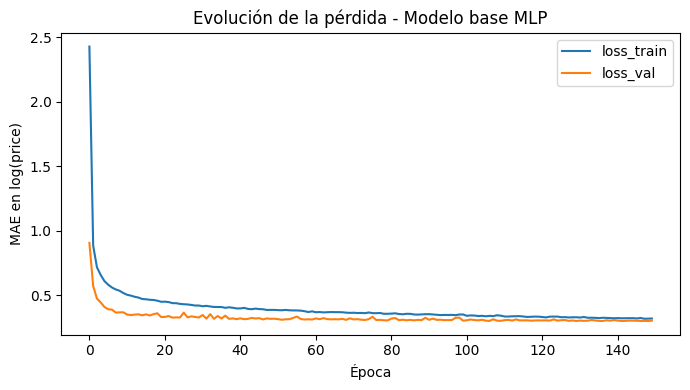

MAE en log(price) - test: 0.2889
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE aproximado en price (escala original): 154.70


In [27]:
import matplotlib.pyplot as plt

# Entreno un primer modelo base con la arquitectura por defecto
# para tener una referencia de desempeño y revisar que el entrenamiento sea estable.

baseline_model = build_mlp_model(
    n_hidden_layers=2,
    units_per_layer=64,
    dropout_rate=0.10,
    learning_rate=0.001
)

# Entrenamiento del modelo base
history_base = baseline_model.fit(
    X_train_nn,
    y_train_nn,
    epochs=150,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Convierto el historial a DataFrame para poder graficar más fácil
hist_base = pd.DataFrame(history_base.history)
hist_base["epoch"] = history_base.epoch

print(hist_base.tail())

# Curva de pérdida (MAE) en entrenamiento y validación
plt.figure(figsize=(7, 4))
plt.plot(hist_base["loss"], label="loss_train")
plt.plot(hist_base["val_loss"], label="loss_val")
plt.xlabel("Época")
plt.ylabel("MAE en log(price)")
plt.title("Evolución de la pérdida - Modelo base MLP")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluación en el conjunto de prueba en escala log(price)
test_loss_log, test_mae_log = baseline_model.evaluate(X_test_nn, y_test_nn, verbose=0)
print(f"MAE en log(price) - test: {test_mae_log:.4f}")

# Paso el error a escala de precio original para tener una idea más intuitiva (en dólares)
y_pred_test_log = baseline_model.predict(X_test_nn).flatten()
y_pred_test_price = np.exp(y_pred_test_log)
y_test_price = np.exp(y_test_nn)

mae_price = np.mean(np.abs(y_pred_test_price - y_test_price))
print(f"MAE aproximado en price (escala original): {mae_price:.2f}")


In [28]:
import matplotlib.pyplot as plt

# Reinicio la lista de resultados para esta nueva búsqueda
hp_results = []

# Defino a mano varias configuraciones más razonables:
# algunas redes pequeñas, otras cercanas al baseline y unas pocas un poco más grandes.
config_1  = {"n_layers": 1, "units": 16,  "dropout": 0.00, "lr": 0.001}
config_2  = {"n_layers": 1, "units": 32,  "dropout": 0.05, "lr": 0.001}
config_3  = {"n_layers": 1, "units": 64,  "dropout": 0.10, "lr": 0.001}

config_4  = {"n_layers": 2, "units": 32,  "dropout": 0.05, "lr": 0.001}
config_5  = {"n_layers": 2, "units": 64,  "dropout": 0.10, "lr": 0.001}   # muy parecido al baseline
config_6  = {"n_layers": 2, "units": 96,  "dropout": 0.15, "lr": 0.001}
config_7  = {"n_layers": 2, "units": 64,  "dropout": 0.10, "lr": 0.0005}

config_8  = {"n_layers": 3, "units": 48,  "dropout": 0.10, "lr": 0.001}
config_9  = {"n_layers": 3, "units": 64,  "dropout": 0.15, "lr": 0.001}
config_10 = {"n_layers": 3, "units": 96,  "dropout": 0.20, "lr": 0.0005}

config_11 = {"n_layers": 4, "units": 48,  "dropout": 0.10, "lr": 0.001}
config_12 = {"n_layers": 4, "units": 64,  "dropout": 0.15, "lr": 0.0005}
config_13 = {"n_layers": 4, "units": 96,  "dropout": 0.20, "lr": 0.001}

config_14 = {"n_layers": 5, "units": 48,  "dropout": 0.15, "lr": 0.001}
config_15 = {"n_layers": 5, "units": 64,  "dropout": 0.20, "lr": 0.0005}

config_list = [
    config_1, config_2, config_3,
    config_4, config_5, config_6, config_7,
    config_8, config_9, config_10,
    config_11, config_12, config_13,
    config_14, config_15
]

print("Número de configuraciones que voy a probar:", len(config_list))

for i, cfg in enumerate(config_list, start=1):
    print("\n====================================")
    print(f"Modelo {i}")
    print(f"Capas: {cfg['n_layers']}, unidades: {cfg['units']}, dropout: {cfg['dropout']}, lr: {cfg['lr']}")
    
    # Construyo el modelo con esta configuración
    model_tmp = build_mlp_model(
        n_hidden_layers=cfg["n_layers"],
        units_per_layer=cfg["units"],
        dropout_rate=cfg["dropout"],
        learning_rate=cfg["lr"]
    )
    
    # Early stopping para no entrenar de más modelos que ya dejaron de mejorar
    early_stop_tmp = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    
    history_tmp = model_tmp.fit(
        X_train_nn,
        y_train_nn,
        epochs=120,
        batch_size=256,
        validation_split=0.2,
        callbacks=[early_stop_tmp],
        verbose=0
    )
    
    # Mejor MAE en validación (log(price))
    best_val_mae_log = float(np.min(history_tmp.history["val_loss"]))
    
    # Evaluación en test en log(price)
    test_loss_log, test_mae_log = model_tmp.evaluate(X_test_nn, y_test_nn, verbose=0)
    
    # Error en la escala original del precio
    y_pred_test_log_tmp = model_tmp.predict(X_test_nn, verbose=0).flatten()
    y_pred_test_price_tmp = np.exp(y_pred_test_log_tmp)
    y_test_price_tmp = np.exp(y_test_nn)
    mae_price_tmp = float(np.mean(np.abs(y_pred_test_price_tmp - y_test_price_tmp)))
    
    epochs_trained = len(history_tmp.history["loss"])
    
    hp_results.append({
        "model_id": i,
        "n_layers": cfg["n_layers"],
        "units": cfg["units"],
        "dropout": cfg["dropout"],
        "learning_rate": cfg["lr"],
        "best_val_mae_log": best_val_mae_log,
        "test_mae_log": float(test_mae_log),
        "mae_price": mae_price_tmp,
        "epochs_trained": epochs_trained,
        "history": history_tmp,
        "model_obj": model_tmp
    })
    
    print(f"Mejor val MAE (log): {best_val_mae_log:.4f}")
    print(f"MAE test (log): {test_mae_log:.4f}")
    print(f"MAE aproximado en price: {mae_price_tmp:.2f}")


Número de configuraciones que voy a probar: 15

Modelo 1
Capas: 1, unidades: 16, dropout: 0.0, lr: 0.001
Mejor val MAE (log): 0.3623
MAE test (log): 0.3267
MAE aproximado en price: 340.12

Modelo 2
Capas: 1, unidades: 32, dropout: 0.05, lr: 0.001
Mejor val MAE (log): 0.3450
MAE test (log): 0.3156
MAE aproximado en price: 164.10

Modelo 3
Capas: 1, unidades: 64, dropout: 0.1, lr: 0.001
Mejor val MAE (log): 0.3347
MAE test (log): 0.3079
MAE aproximado en price: 187.64

Modelo 4
Capas: 2, unidades: 32, dropout: 0.05, lr: 0.001
Mejor val MAE (log): 0.3177
MAE test (log): 0.3061
MAE aproximado en price: 205.55

Modelo 5
Capas: 2, unidades: 64, dropout: 0.1, lr: 0.001
Mejor val MAE (log): 0.3192
MAE test (log): 0.3092
MAE aproximado en price: 200.59

Modelo 6
Capas: 2, unidades: 96, dropout: 0.15, lr: 0.001
Mejor val MAE (log): 0.3093
MAE test (log): 0.2994
MAE aproximado en price: 174.52

Modelo 7
Capas: 2, unidades: 64, dropout: 0.1, lr: 0.0005
Mejor val MAE (log): 0.3147
MAE test (log): 0

Modelos ordenados por mejor MAE de validación (log):
   model_id  n_layers  units  dropout  learning_rate  best_val_mae_log  \
0         6         2     96     0.15         0.0010          0.309326   
1         7         2     64     0.10         0.0005          0.314658   
2         9         3     64     0.15         0.0010          0.315863   
3         8         3     48     0.10         0.0010          0.317437   
4         4         2     32     0.05         0.0010          0.317666   
5         5         2     64     0.10         0.0010          0.319249   
6        11         4     48     0.10         0.0010          0.324279   
7         3         1     64     0.10         0.0010          0.334653   
8        12         4     64     0.15         0.0005          0.339178   
9        14         5     48     0.15         0.0010          0.343877   

   test_mae_log   mae_price  epochs_trained  
0      0.299423  174.516510              63  
1      0.304477  232.956680             

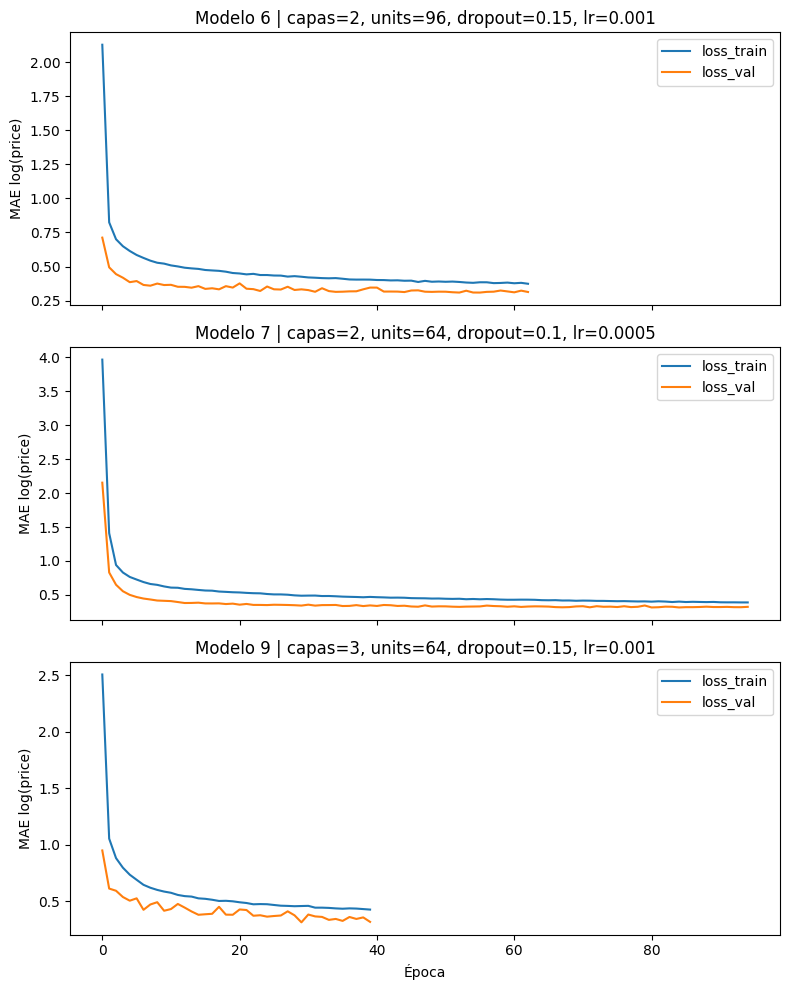

In [29]:
# Paso los resultados de la búsqueda de hiperparámetros a un DataFrame limpio

hp_results_df = pd.DataFrame([
    {
        "model_id": r["model_id"],
        "n_layers": r["n_layers"],
        "units": r["units"],
        "dropout": r["dropout"],
        "learning_rate": r["learning_rate"],
        "best_val_mae_log": r["best_val_mae_log"],
        "test_mae_log": r["test_mae_log"],
        "mae_price": r["mae_price"],
        "epochs_trained": r["epochs_trained"]
    }
    for r in hp_results
])

# Ordeno los modelos por el mejor MAE en validación (entre más bajo, mejor)
hp_results_df = hp_results_df.sort_values(
    by="best_val_mae_log",
    ascending=True
).reset_index(drop=True)

print("Modelos ordenados por mejor MAE de validación (log):")
print(hp_results_df.head(10))

# Me quedo con los IDs de los 3 mejores modelos según validación
top3_ids = hp_results_df["model_id"].head(3).tolist()
print("\nIDs de los 3 mejores modelos:", top3_ids)

# Función auxiliar para recuperar el diccionario completo de un modelo dado su ID
def get_result_by_id(model_id):
    for r in hp_results:
        if r["model_id"] == model_id:
            return r
    return None

# Grafico las curvas de loss (train y val) para los 3 mejores modelos
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

for ax, mid in zip(axes, top3_ids):
    res = get_result_by_id(mid)
    history_dict = res["history"].history
    
    ax.plot(history_dict["loss"], label="loss_train")
    ax.plot(history_dict["val_loss"], label="loss_val")
    
    titulo = (
        f"Modelo {mid} | capas={res['n_layers']}, "
        f"units={res['units']}, dropout={res['dropout']}, lr={res['learning_rate']}"
    )
    ax.set_title(titulo)
    ax.set_ylabel("MAE log(price)")
    ax.legend()

axes[-1].set_xlabel("Época")
plt.tight_layout()
plt.show()


In [30]:
# Me quedo con el mejor modelo según el MAE de validación en log(price)
best_row = hp_results_df.iloc[0]
best_id = int(best_row["model_id"])

print("Mejor modelo según validación:")
print(best_row)

# Función auxiliar para recuperar el resultado completo del modelo
def get_result_by_id(model_id):
    for r in hp_results:
        if r["model_id"] == model_id:
            return r
    return None

best_result = get_result_by_id(best_id)

# Guardo el modelo final en una variable clara para usarlo después
final_mlp_model = best_result["model_obj"]

# Vuelvo a evaluar en test por si quiero confirmar números
test_loss_log_final, test_mae_log_final = final_mlp_model.evaluate(
    X_test_nn,
    y_test_nn,
    verbose=0
)

print(f"\nMAE test (log) modelo final: {test_mae_log_final:.4f}")

# Predicciones del modelo final sobre el conjunto de prueba
y_pred_test_log_final = final_mlp_model.predict(X_test_nn, verbose=0).flatten()

# Errores en escala log(price)
residuos_log = y_test_nn - y_pred_test_log_final

# Desviación estándar de los residuos en log(price)
sigma_log = float(np.std(residuos_log))

# Paso a escala original para tener una idea del error en precio
y_pred_test_price_final = np.exp(y_pred_test_log_final)
y_test_price_final = np.exp(y_test_nn)

mae_price_final = float(np.mean(np.abs(y_pred_test_price_final - y_test_price_final)))

print(f"Desviación estándar de los residuos en log(price): {sigma_log:.4f}")
print(f"MAE aproximado en price (modelo final): {mae_price_final:.2f}")

Mejor modelo según validación:
model_id              6.000000
n_layers              2.000000
units                96.000000
dropout               0.150000
learning_rate         0.001000
best_val_mae_log      0.309326
test_mae_log          0.299423
mae_price           174.516510
epochs_trained       63.000000
Name: 0, dtype: float64

MAE test (log) modelo final: 0.2994
Desviación estándar de los residuos en log(price): 0.4313
MAE aproximado en price (modelo final): 174.52


In [31]:
# Comparo el modelo base que entrené al inicio con el mejor modelo encontrado
# en la búsqueda de hiperparámetros, para quedarme con uno solo como modelo final

# Evaluación modelo base
base_test_loss_log, base_test_mae_log = baseline_model.evaluate(
    X_test_nn,
    y_test_nn,
    verbose=0
)

y_pred_base_log = baseline_model.predict(X_test_nn, verbose=0).flatten()
y_pred_base_price = np.exp(y_pred_base_log)
y_test_price_comp = np.exp(y_test_nn)
base_mae_price = float(np.mean(np.abs(y_pred_base_price - y_test_price_comp)))

# Evaluación modelo final (mejor de la búsqueda)
final_test_loss_log, final_test_mae_log = final_mlp_model.evaluate(
    X_test_nn,
    y_test_nn,
    verbose=0
)

y_pred_final_log = final_mlp_model.predict(X_test_nn, verbose=0).flatten()
y_pred_final_price = np.exp(y_pred_final_log)
final_mae_price = float(np.mean(np.abs(y_pred_final_price - y_test_price_comp)))

# Resumen comparativo en un DataFrame para verlo más claro
comparacion_modelos = pd.DataFrame({
    "modelo": ["baseline", "mejor_busqueda"],
    "test_mae_log": [base_test_mae_log, final_test_mae_log],
    "mae_price": [base_mae_price, final_mae_price]
})

print("Comparación de desempeño entre modelo base y mejor modelo de la búsqueda:")
print(comparacion_modelos)

# Elijo el modelo definitivo según el MAE en log(price) del conjunto de prueba
if final_test_mae_log <= base_test_mae_log:
    modelo_definitivo = final_mlp_model
    nombre_modelo_definitivo = "mejor_busqueda"
else:
    modelo_definitivo = baseline_model
    nombre_modelo_definitivo = "baseline"

print(f"\nModelo definitivo seleccionado: {nombre_modelo_definitivo}")


Comparación de desempeño entre modelo base y mejor modelo de la búsqueda:
           modelo  test_mae_log   mae_price
0        baseline      0.288877  154.701752
1  mejor_busqueda      0.299423  174.516510

Modelo definitivo seleccionado: baseline


In [32]:
# Cálculo de la dispersión de errores (sigma) para el modelo definitivo
# y definición de una función que, dada una propiedad, devuelva:
# - precio central estimado
# - precio mínimo y máximo razonable usando k * sigma en log(price)

# Predicciones del modelo definitivo sobre el conjunto de entrenamiento
y_pred_train_log_def = modelo_definitivo.predict(X_train_nn, verbose=0).flatten()

# Residuos en log(price) usando todo el set de entrenamiento
residuos_log_def = y_train_nn - y_pred_train_log_def

# Desviación estándar de los residuos en log(price) para el modelo definitivo
sigma_log_def = float(np.std(residuos_log_def))
print(f"Sigma (std de residuos en log(price)) del modelo definitivo: {sigma_log_def:.4f}")

def recomendar_precio_y_rango(x_features, k=1.0):
    # Me aseguro de que la entrada sea un arreglo 2D de tipo float32
    x_array = np.array(x_features, dtype="float32").reshape(1, -1)
    
    # Predicción en log(price)
    y_pred_log = modelo_definitivo.predict(x_array, verbose=0).flatten()[0]
    
    # Paso a escala original
    precio_central = float(np.exp(y_pred_log))
    
    # Construyo rango usando la sigma estimada en log(price)
    precio_min = float(np.exp(y_pred_log - k * sigma_log_def))
    precio_max = float(np.exp(y_pred_log + k * sigma_log_def))
    
    return precio_central, precio_min, precio_max

# Ejemplo rápido usando la primera observación del conjunto de prueba
ejemplo_x = X_test_nn[0]
precio_central_ej, precio_min_ej, precio_max_ej = recomendar_precio_y_rango(ejemplo_x, k=0.5)

print("\nEjemplo de recomendación de precio para una propiedad del conjunto de prueba (primera fila de test):")
print(f"Precio central estimado: {precio_central_ej:.2f}")
print(f"Rango razonable: [{precio_min_ej:.2f}, {precio_max_ej:.2f}]")


Sigma (std de residuos en log(price)) del modelo definitivo: 0.4427

Ejemplo de recomendación de precio para una propiedad del conjunto de prueba (primera fila de test):
Precio central estimado: 266.21
Rango razonable: [213.35, 332.17]


In [33]:
# Función para aplicar el modelo definitivo a un DataFrame de propiedades
# y obtener, para cada fila, el precio central estimado y el rango razonable.

def recomendar_rango_para_df(df_props, k=0.5):
    # Verifico que el DataFrame tenga todas las columnas necesarias
    missing_cols = [c for c in feature_cols_nn if c not in df_props.columns]
    if len(missing_cols) > 0:
        print("Faltan columnas en el DataFrame para poder usar el modelo:")
        print(missing_cols)
        raise ValueError("El DataFrame de entrada no tiene todas las variables requeridas.")
    
    # Ordeno las columnas según el orden de entrenamiento
    X_mat = df_props[feature_cols_nn].astype("float32").values
    
    precios_centrales = []
    precios_min = []
    precios_max = []
    
    # Recorro fila por fila y aplico la función de recomendación ya definida
    for i in range(X_mat.shape[0]):
        precio_central, precio_min, precio_max = recomendar_precio_y_rango(
            X_mat[i],
            k=k
        )
        precios_centrales.append(precio_central)
        precios_min.append(precio_min)
        precios_max.append(precio_max)
    
    # Armo un DataFrame de salida con las columnas originales + las predicciones
    df_resultado = df_props.copy()
    df_resultado["price_pred_central"] = precios_centrales
    df_resultado["price_pred_min"] = precios_min
    df_resultado["price_pred_max"] = precios_max
    
    return df_resultado

# Prueba rápida con algunas filas de la base original
ejemplo_df = df.iloc[:5].copy()

df_con_rangos = recomendar_rango_para_df(ejemplo_df, k=0.5)

print(df_con_rangos[["price", "price_pred_central", "price_pred_min", "price_pred_max"]])


   price  price_pred_central  price_pred_min  price_pred_max
0   66.0           67.084984       53.764709       83.705391
1   76.0           88.064064       70.578217      109.882050
2   97.0          129.212799      103.556526      161.225464
3   60.0           64.547127       51.730759       80.538773
4  425.0          430.113129      344.710632      536.674255
